In [1]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'E:\\User\\Stevens\\Spring 2024\\PTO - Fairness\\myGit\\myUtils')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Utility functions
def genData(num_data, num_features, num_items, seed=42, Q=100, dim=1, deg=1, noise_width=0.5, epsilon=0.1):
    rnd = np.random.RandomState(seed)
    n = num_data
    p = num_features
    m = num_items
    
    # Split the population into group A (1/4) and group B (3/4)
    group_A_size = n // 4
    group_B_size = n - group_A_size
    
    # Generate x with a bias for group A
    x = np.zeros((n, m, p))
    x[:group_A_size] = rnd.normal(0.5, 1, (group_A_size, m, p))  # Slightly higher mean for group A
    x[group_A_size:] = rnd.normal(0, 1, (group_B_size, m, p))   # Standard distribution for group B
    
    B = rnd.binomial(1, 0.5, (m, p))

    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            values = (np.dot(B[j], x[i, j].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
            values *= 5
            values /= 3.5 ** deg
            epislon = rnd.uniform(1 - noise_width, 1 + noise_width, 1)
            values *= epislon
            
            # Introduce bias for c: Group A has slightly higher values, Group B slightly lower
            if i < group_A_size:
                values *= 1.1  # Increase c for Group A
            else:
                values *= 0.9  # Decrease c for Group B
            
            values = np.ceil(values)
            c[i, j] = values

    c = c.astype(np.float64)
    
    w = rnd.normal(0, 1, (m, p))
    
    # Generate b with a slight bias for group A
    b = np.zeros((n, m))
    b[:group_A_size] = rnd.normal(0.5, 1, (group_A_size, m))  # Slightly higher bias for group A
    b[group_A_size:] = rnd.normal(0, 1, (group_B_size, m))    # Standard distribution for group B
    
    r = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            r[i, j] = np.dot(w[j], x[i, j])**2 + b[i, j]
            
            # Introduce bias for r: Group A has slightly lower values, Group B slightly higher
            if i < group_A_size:
                r[i, j] -= 0.2  # Decrease r for Group A
            else:
                r[i, j] += 0.2  # Increase r for Group B

    r = 1 / (1 + np.exp(-r))  # Sigmoid function to r

    return x, r, c, Q


class optModel:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items
        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__
    
    def setObj2(self, a, r, b, c, Q, epsilon=0.01, alpha=0.5):
        if alpha == 1:
            self.objective = cp.sum(cp.log(a * r + b * self.d + epsilon))
        else:
            self.objective = cp.sum(cp.power(a * r + b * self.d + epsilon, 1 - alpha)) / (1 - alpha)
        
        self.constraints = [
            cp.sum(cp.multiply(c, self.d)) <= Q
        ]
        
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)
        self.a = a
        self.r = r
        self.b = b
        self.c = c
        self.Q = Q
        self.epsilon = epsilon


    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    
    def solveS(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val


    def solve(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        c = c.cpu().numpy() if isinstance(c, torch.Tensor) else c
        r = r.cpu().numpy() if isinstance(r, torch.Tensor) else r
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c
    
    def solveC2(self):
        """
        A method to solve the optimization problem in closed form using the given formula.

        Returns:
            tuple: optimal solution and optimal value
        """
        if self.alpha == 1:
            raise ValueError("Work in progress")

        a = self.a
        r = self.r
        b = self.b
        c = self.c
        epsilon = self.epsilon
        Q = self.Q
        alpha = self.alpha

        b_inverse_alpha = b ** (-1 / alpha)
        c_over_b = c / b
        ar_plus_epsilon = a * r + epsilon

        S1 = np.sum(c_over_b * ar_plus_epsilon)
        S2 = np.sum(c_over_b ** (1 - 1 / alpha))

        d_star = b_inverse_alpha * (Q + S1) / S2 - ar_plus_epsilon * b_inverse_alpha / b

        opt_val_c2 = np.sum((a * r + b * d_star + epsilon) ** (1 - alpha)) / (1 - alpha)

        return d_star, opt_val_c2


    
class optDataset(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha=0.5, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed

        self.sols, self.objs = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
        
        return np.array(opt_sols), np.array(opt_objs)

    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModel(r, c, self.Q, self.alpha)
        if self.closed:
            return self.model.solveC()
        else:
            return self.model.solve()

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        """
        A method to retrieve data

        Args:
            index (int): data index

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        return (
            torch.FloatTensor(self.feats[index]), # x 
            torch.FloatTensor(self.costs[index]), # c
            torch.FloatTensor(self.r[index]), # r 
            torch.FloatTensor(self.sols[index]),# optimal solution
            torch.FloatTensor(self.objs[index]), # objective value
        )
    
class LinearRegressionModel(nn.Module):
    def __init__(self, num_items, num_features):
        super(LinearRegressionModel, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.linears = nn.ModuleList([nn.Linear(num_features, 1) for _ in range(num_items)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.linears[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)
    

def regret(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, r, d, z  = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegret(optModel, c[j].to("cpu").detach().numpy(), rp[j], r[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)

def objValue(d, r, alpha=0.5):
    """
    A function to calculate objective value
    """
    if alpha == 1:
        return np.sum(np.log(np.multiply(r, d)))
    else:
        return np.sum(np.power(np.multiply(r, d), 1 - alpha)) / (1 - alpha)



def calRegret(optmodel, cost, pred_r, true_r, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha=0.5)
    sol, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha=0.5)
    # loss
    loss = true_obj - obj
    return loss

# Define the visualization function
def visLearningCurve(loss_log, loss_log_regret):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.03)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [3]:
num_data = 400
num_features = 20
num_items = 5

In [4]:
x, r, c, Q = genData(num_data, num_features, num_items)
optmodel = optModel(r, c, Q, alpha=0.5)

In [5]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)

# Create datasets and dataloaders
dataset_train = optDataset(x_train, c_train, r_train, Q, alpha=0.5, closed=False)
dataset_test = optDataset(x_test, c_test, r_test, Q, alpha=0.5, closed=False)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 80/80 [00:00<00:00, 80254.56it/s]


In [6]:
r[0]

array([1.        , 0.99994548, 1.        , 0.93952484, 0.99995553])

In [7]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass: Compute the predicted rewards (rp)

            # Compute the loss using your custom loss function
            loss = loss_func(rp, r, c, z)

            # Perform backward pass to compute the gradients
            loss.backward(retain_graph=True)

            # Print the gradient of the loss with respect to the predicted reward (rp)
            # This corresponds to the term ∂l/∂r in the chain rule
            # print("Gradient of loss w.r.t. pred_r (∂l/∂r):")
            # print(rp.grad)  # rp.grad is None because the gradient is manually computed in the custom backward function

            # Print the gradients of the loss with respect to the model parameters (∂l/∂θ)
            # These are computed automatically by PyTorch using the chain rule: ∂l/∂θ = (∂l/∂r) * (∂r/∂θ)
            # print("\nGradients of loss w.r.t. model parameters (∂l/∂θ):")
            # for param in predmodel.parameters():
            #     if param.grad is not None:
            #         print(f"Parameter: {param}")
            #         print(f"Gradient (∂l/∂θ): {param.grad}")

            # Update the model parameters using the optimizer
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))

    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [8]:
from torch.autograd import Function

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        for i in range(batch_size):
            # opt sol for pred cost
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            # obj with true cost
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses

        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):

        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                perturbed_pred_r[j] += epsilon
                
                # Compute loss with perturbed pred_r
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                obj = objValue(sol, true_r_np, alpha=alpha)
                loss_perturbed = true_obj[i] - obj
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            grad_pred_r[i] = torch.tensor(gradient, device=pred_r.device)
        
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


Epoch  1,  Loss:    0.1086,  Regret:  0.8231%
Epoch  2,  Loss:    0.0662,  Regret:  0.5548%
Epoch  3,  Loss:    0.1057,  Regret:  0.4800%
Epoch  4,  Loss:    0.0800,  Regret:  0.4668%
Epoch  5,  Loss:    0.0572,  Regret:  0.4725%
Epoch  6,  Loss:    0.0717,  Regret:  0.4803%
Epoch  7,  Loss:    0.0753,  Regret:  0.4869%
Epoch  8,  Loss:    0.1510,  Regret:  0.4832%
Epoch  9,  Loss:    0.0652,  Regret:  0.4825%
Epoch 10,  Loss:    0.0858,  Regret:  0.4772%
Total Elapsed Time: 18.34 Sec.


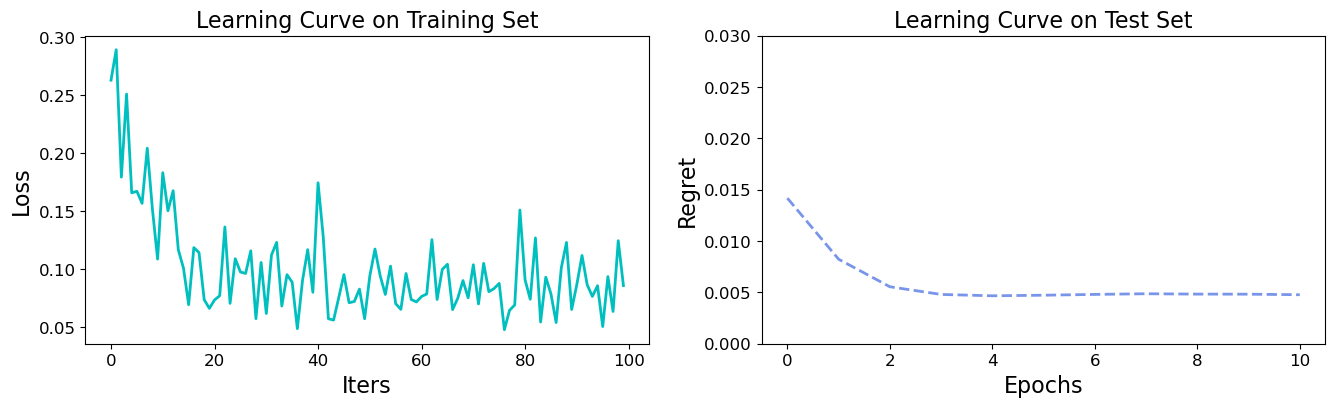

In [9]:
# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel,Q)

# Run the training
loss_log, loss_log_regret = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret)

In [10]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)
            
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))
    predmodel.eval()
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

# MSE LOSS

Epoch  1,  Loss:    0.0778,  Regret:  0.6677%
Epoch  2,  Loss:    0.0494,  Regret:  0.5863%
Epoch  3,  Loss:    0.0376,  Regret:  0.5704%
Epoch  4,  Loss:    0.0326,  Regret:  0.5658%
Epoch  5,  Loss:    0.0373,  Regret:  0.5655%
Epoch  6,  Loss:    0.0379,  Regret:  0.5646%
Epoch  7,  Loss:    0.0296,  Regret:  0.5640%
Epoch  8,  Loss:    0.0352,  Regret:  0.5644%
Epoch  9,  Loss:    0.0236,  Regret:  0.5647%
Epoch 10,  Loss:    0.0341,  Regret:  0.5647%
Total Elapsed Time: 116.28 Sec.


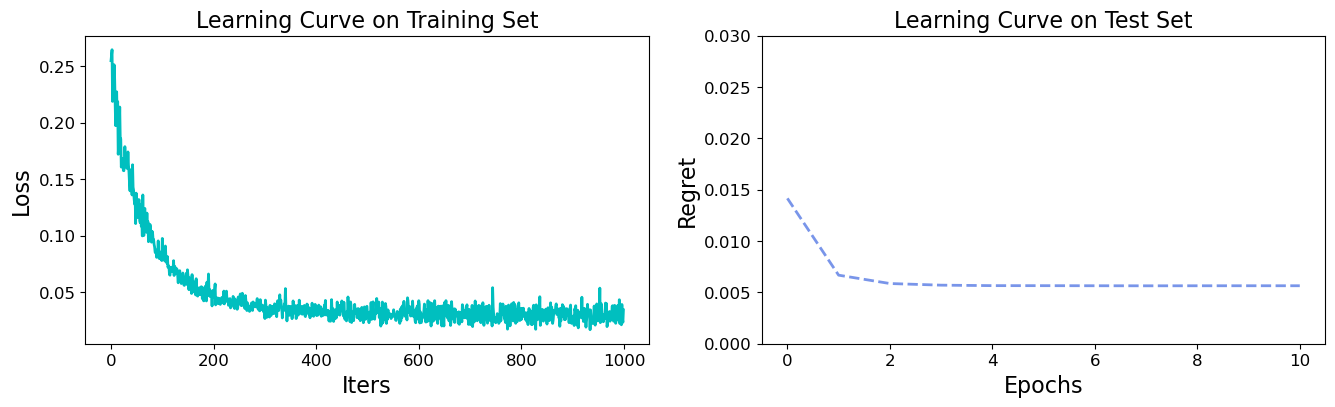

In [11]:
# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = nn.MSELoss()

# Run the training
loss_log, loss_log_regret = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret)

# CLOSED FORM GRADIENT

In [12]:
def closed_form_solution_and_gradient(c, r, Q=Q, alpha=0.5):
    """
    Compute the closed-form solution d* and its gradient with respect to r.

    Args:
        c (np.ndarray): cost vector
        r (np.ndarray): prediction vector
        Q (float): budget
        alpha (float): parameter alpha

    Returns:
        tuple: optimal solution (d*), gradient of d* with respect to r
    """
    S = np.sum(c ** (1 - 1 / alpha) * r ** (-1 + 1 / alpha))
    d_star = (c ** (-1 / alpha) * r ** (-1 + 1 / alpha) * Q) / S
    
    # Gradient of d* with respect to r
    grad_d_star_r = np.zeros_like(r)
    for i in range(len(r)):
        A_i = c[i] ** (-1 / alpha) * r[i] ** (-1 + 1 / alpha)
        grad_d_star_r[i] = Q * ((-1 + 1 / alpha) * c[i] ** (-1 / alpha) * r[i] ** (-2 + 1 / alpha) * (S - c[i] ** (1 - 1 / alpha) * r[i] ** (-1 + 1 / alpha))) / S**2
    
    return grad_d_star_r

In [13]:
class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        # Keep tensors within PyTorch
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        solutions = []  # Save solutions for use in backward pass
        
        for i in range(batch_size):
            # Solve the optimization problem using pred_r
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            solutions.append(sol)
            
            # Calculate the objective with the true reward
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            # Calculate the regret (loss)
            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.solutions = solutions  # Save the solutions
        ctx.losses = losses

        return losses.mean()

    @staticmethod
    def backward(ctx, grad_output):
        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        solutions = ctx.solutions

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)

        epsilon = 1e-5  # Perturbation step size for finite differences
        
        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()

            # Analytical gradient of d(rp) w.r.t rp using the provided closed-form formula
            grad_d_star_r = closed_form_solution_and_gradient(cost_np, pred_r_np, Q=Q, alpha=alpha)
            
            # Compute loss with respect to d(rp) by finite differences
            perturbed_grad_loss_d_rp = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                
                # Solve the optimization problem with perturbed predicted rewards
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                
                # Calculate the objective with true rewards
                obj_perturbed = objValue(sol, true_r_np, alpha=alpha) + epsilon
                loss_perturbed = true_obj[i] - obj_perturbed
                
                # Calculate the gradient of the loss with respect to d(rp)
                perturbed_grad_loss_d_rp[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            # Multiply the gradients: loss/d(rp) * d(rp)/rp
            grad_pred_r[i] = torch.tensor(perturbed_grad_loss_d_rp, device=pred_r.device) * torch.tensor(grad_d_star_r, device=pred_r.device)

        # Scale the gradient by grad_output
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None


In [14]:
class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [15]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    predmodel.train()
    
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    mse_loss_log = []  # New MSE loss log
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)  # Forward pass

            # Compute the regret loss (original loss)
            loss = loss_func(rp, r, c, z)
            # Compute MSE loss (new fixed metric)
            mse_loss = mse_loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())
            mse_loss_log.append(mse_loss.item())  # Log the MSE loss

        # Compute and log the regret loss after each epoch
        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f},  MSE: {mse_loss.item():7.4f},  Regret: {regret_loss * 100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")
    return loss_log, loss_log_regret, mse_loss_log  # Return MSE loss log as well

Epoch  1,  Loss:    0.1679,  Regret:  0.8423%
Epoch  2,  Loss:    0.0938,  Regret:  0.6209%
Epoch  3,  Loss:    0.0686,  Regret:  0.5793%
Epoch  4,  Loss:    0.0801,  Regret:  0.5690%
Epoch  5,  Loss:    0.0841,  Regret:  0.5660%
Epoch  6,  Loss:    0.0519,  Regret:  0.5649%
Epoch  7,  Loss:    0.1416,  Regret:  0.5641%
Epoch  8,  Loss:    0.1358,  Regret:  0.5638%
Epoch  9,  Loss:    0.0894,  Regret:  0.5636%
Epoch 10,  Loss:    0.0785,  Regret:  0.5635%
Total Elapsed Time: 2011.70 Sec.


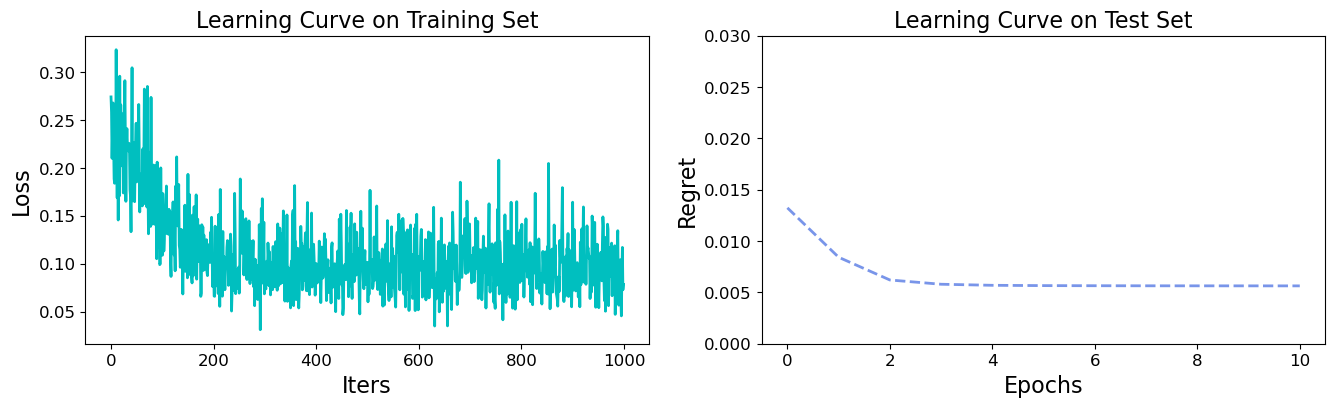

In [16]:
# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel,Q)

# Run the training
loss_log, loss_log_regret = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret)

# Matrix Inversion

In [17]:
import numpy as np
from scipy.linalg import solve

def is_invertible(matrix):
    return np.linalg.cond(matrix) < 1 / np.finfo(matrix.dtype).eps

def solve_rd_matrix_system(r, c, Q, alpha, d_i, mu, lambda_i):
    n = len(r)
    
    A_elements = [alpha * r[i]**2 * (r[i] * d_i[i])**(-alpha - 1) for i in range(n)]
    H_dd = np.diag(A_elements)
    
    B = -np.eye(n)
    
    C = np.zeros((n, 1))
    for i in range(n):
        C[i, 0] = c[i]
    
    D = np.diag(d_i)
    M = np.zeros((1, n))
    M[0, :] = mu * c
    
    Lambda = np.diag(lambda_i)
    
    LHS = np.block([
        [H_dd, B, C],
        [Lambda, D, np.zeros((n, 1))],
        [M, np.zeros((1, n)), np.array([[np.sum(c * d_i) - Q]])]
    ])
    
    v = np.array([-alpha * r[i] * (r[i] * d_i[i])**(-alpha - 1) for i in range(n)])
    RHS = np.hstack([v, np.zeros(n), np.zeros(1)])
    
    if is_invertible(LHS):
        solution = solve(LHS, RHS)
        d_r_derivatives = solution[:n]
        lambda_r_derivatives = solution[n:2*n]
        mu_r_derivative = solution[2*n:]
        
        return d_r_derivatives
    else:
        return {
            "error": "LHS matrix is not invertible. Check problem formulation or input data."
        }


In [18]:
dataset_train.sols[0]
dataset_train.objs[0]
predmodel = LinearRegressionModel(num_items, num_features).to(device)
dataset_train.r[0]

rp = predmodel(torch.FloatTensor(dataset_train.feats).to(device))
rp[0].retain_grad()

predmodel.eval()
predmodel.state_dict()

# regret loss

regret_loss = calRegret(optmodel, dataset_train.costs[0], rp[0].detach().cpu().numpy(), dataset_train.r[0], dataset_train.objs[0].item())
regret_loss = torch.tensor(regret_loss, requires_grad=True)
regret_loss.retain_grad()
torch.autograd.grad(regret_loss, rp[0], allow_unused=True)

array([16.96688636,  1.45549138,  7.91241912,  1.19535837,  7.92434056])

array([23.68247768])

array([0.95160436, 1.        , 0.99849542, 0.82127478, 0.99999982])

LinearRegressionModel(
  (linears): ModuleList(
    (0-4): 5 x Linear(in_features=20, out_features=1, bias=True)
  )
)

OrderedDict([('linears.0.weight',
              tensor([[-0.1080,  0.0380,  0.1669,  0.1749,  0.1027, -0.1646, -0.1200, -0.0491,
                       -0.0412,  0.0184, -0.2053,  0.0696, -0.1706, -0.1415, -0.1859,  0.1948,
                       -0.2117,  0.1687, -0.0075, -0.0260]], device='cuda:0')),
             ('linears.0.bias', tensor([0.1399], device='cuda:0')),
             ('linears.1.weight',
              tensor([[-0.0207,  0.1402,  0.1617, -0.1941,  0.0860,  0.0422,  0.0481,  0.0326,
                        0.0612, -0.1076, -0.0286,  0.2125,  0.1502, -0.0084, -0.2103,  0.0098,
                       -0.1523,  0.1818, -0.1357, -0.0161]], device='cuda:0')),
             ('linears.1.bias', tensor([-0.0496], device='cuda:0')),
             ('linears.2.weight',
              tensor([[ 0.0398,  0.2104,  0.0212,  0.1295,  0.1736,  0.1805, -0.0772, -0.0500,
                        0.1078, -0.0610,  0.1047, -0.0489, -0.1517,  0.0910,  0.0343,  0.0997,
                        0.2222,

(None,)

In [19]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, num_items, num_features):
        super(SimpleNeuralNetwork, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            ) for _ in range(num_items)
        ])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.layers[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)


from sklearn.ensemble import RandomForestRegressor

# Define a class to wrap RandomForestRegressor for use in the framework
class RandomForestModel:
    def __init__(self, num_items, num_features, n_estimators=100, random_state=42):
        self.num_items = num_items
        self.models = [RandomForestRegressor(n_estimators=n_estimators, random_state=random_state) for _ in range(num_items)]

    def fit(self, x, y):
        for i in range(self.num_items):
            self.models[i].fit(x[:, i, :], y[:, i])

    def predict(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(self.models[i].predict(x[:, i, :]).reshape(-1, 1))
        return np.concatenate(outputs, axis=1)


In [20]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)
            
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = loss_func(rp, r, c, z)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))
    predmodel.eval()
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [21]:
from torch.autograd import Function

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        for i in range(batch_size):
            # opt sol for pred cost
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            # obj with true cost
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses

        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):

        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                perturbed_pred_r[j] += epsilon
                
                # Compute loss with perturbed pred_r
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                obj = objValue(sol, true_r_np, alpha=alpha)
                loss_perturbed = true_obj[i] - obj
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            grad_pred_r[i] = torch.tensor(gradient, device=pred_r.device)
        
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


Epoch  1,  Loss:    0.1275,  Regret:  0.4926%
Epoch  2,  Loss:    0.0849,  Regret:  0.4059%
Epoch  3,  Loss:    0.0658,  Regret:  0.3465%
Epoch  4,  Loss:    0.0479,  Regret:  0.3198%
Epoch  5,  Loss:    0.0464,  Regret:  0.2954%
Epoch  6,  Loss:    0.0411,  Regret:  0.2969%
Epoch  7,  Loss:    0.0526,  Regret:  0.2959%
Epoch  8,  Loss:    0.0357,  Regret:  0.2842%
Epoch  9,  Loss:    0.0336,  Regret:  0.2910%
Epoch 10,  Loss:    0.0238,  Regret:  0.2965%
Total Elapsed Time: 1959.27 Sec.


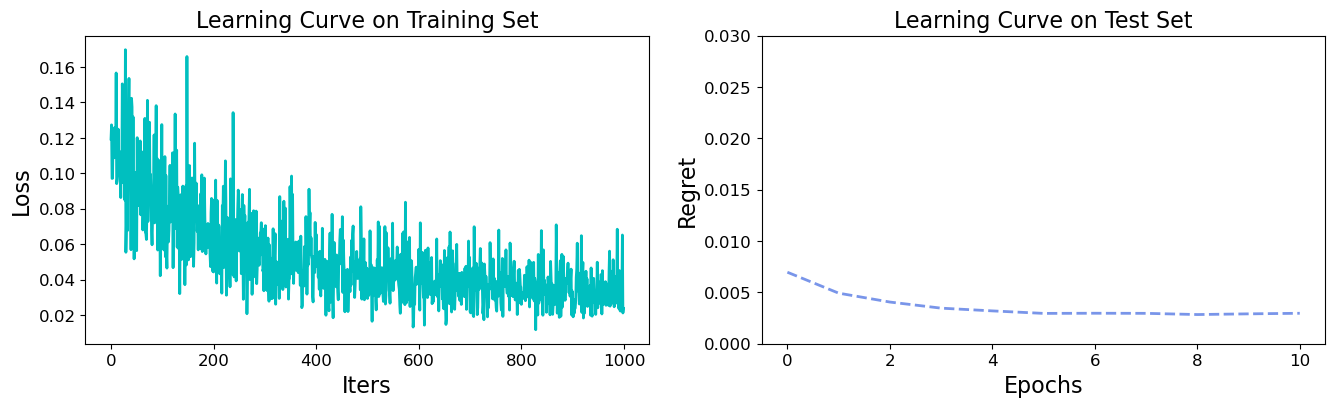

In [22]:
# Train the neural network model
optmodel = optModel
nn_model = SimpleNeuralNetwork(num_items, num_features).to(device)
criterion = RegretLoss(optModel,Q)
nn_loss_log, nn_loss_log_regret = trainModel(nn_model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves for the neural network
visLearningCurve(nn_loss_log, nn_loss_log_regret)